In [8]:
import numpy as np
from expansion_tools.delay_analysis import gamma_radio_delay_analysis_vs_v_exp
from astropy.table import Table
from astropy.units import Unit as u
import glob
from jetset.jet_timedep import JetTimeEvol


In [9]:
def get_p_index(temp_ev,time_obs_seconds,log_gmin,log_gmax,plot=False,):
    temp_ev.set_time(time=time_obs_seconds,frame='obs')
    temp_ev.rad_region.jet.emitters_distribution.n_gamma_e
    fig=plt.figure(dpi=100)
    
    y,x= temp_ev.rad_region.jet.emitters_distribution.n_gamma_e,temp_ev.rad_region.jet.emitters_distribution.gamma_e
    msk=np.logical_and(y>0,x>0)
    y=y[msk]
    x=x[msk]
    
    x,y=np.log10([x,y])
   
    
    if plot is True:
        plt.plot(x,y)
        plt.xlim(-1,5)
        plt.ylim(-20,5)
    
    msk=np.logical_and(x>log_gmin,x<log_gmax)
    x1=x[msk]
    y1=y[msk]

    p1 = np.polyfit(x1, y1, 1)
    if plot is True:
        plt.plot(x1,np.poly1d(p1)(x1))
    
    print('p=',p1)
    return p1[0]

In [10]:
def update_sed_plot(p):
    p.sedplot.legend(bbox_to_anchor=(1, 1), loc='best', ncol=1,fontsize=15)
    p.sedplot.xaxis.label.set_size(15)
    p.sedplot.xaxis.set_tick_params(labelsize=15)

    p.secaxy.xaxis.label.set_size(15)
    p.secaxy.xaxis.set_tick_params(labelsize=15)

    p.sedplot.yaxis.label.set_size(15)
    p.sedplot.yaxis.set_tick_params(labelsize=15)
    p.fig.tight_layout()

In [11]:
def delta_t_obs(z,delta,t_exp,beta_exp,R0,nu_0,nu_r,p,m_B):
    
    return (t_exp*(1+z)/delta)+t_peak_obs(z,delta,beta_exp,R0,nu_0,nu_r,p,m_B)

def t_peak_obs(z,delta,beta_exp,R0,nu_0,nu_r,p,m_B):
    psi=(p+4)/(4+m_B*(p+2))
    a=(R0/(beta_exp*3E10))
    b=(nu_0/nu_r)**(psi)
    return ((1+z)/delta)*(a*(b-1))

def t_decay_obs(z,delta,beta_exp,R0,nu_0,nu_r,p,m_B):
    psi=(p+4)/(m_B*(p+2)+4)
    a=(R0/(m_B*beta_exp*3E10))
    b=(nu_0/nu_r)**(psi)
    return ((1+z)/delta)*(a*b)

def t_rise_obs(z,delta,beta_exp,R0,nu_0,nu_r,p,m_B):
    return t_peak_obs(z,delta,beta_exp,R0,nu_0,nu_r,p,m_B)/2

In [12]:
def get_evenlope_index(m_B,p_e,c=0.5,ssa_index=2.5):
    a=m_B*c
    psi=((m_B*(p_e+2)+4))/(p_e+4)
    m=(a-ssa_index*psi)/(-ssa_index*psi)
    print('m',m,'m_B',m_B)
    return m

In [13]:
def get_nu_SSA(p,nu_max):
    tau_max=(2/5)*p**(1/3)*np.log(p)
    alpha=-(p-1)*0.5
    c=tau_max**(1/(alpha-5/2))
    return nu_max/c




In [14]:
table_cooling=Table.read('temp_ev_analysis_beta_exp_trends/gamma_radio_delay_fit_vs_beta_exp.ecsv')
table_no_cooling=Table.read('temp_ev_analysis_beta_exp_trends_no_cooling/gamma_radio_delay_fit_vs_beta_exp.ecsv')
table_no_cooling_m_B_2=Table.read('temp_ev_analysis_beta_exp_trends_no_synch_cooling/gamma_radio_delay_fit_vs_beta_exp.ecsv')


In [15]:
ID_beta=0
beta=table_no_cooling['beta_exp'][ID_beta]
temp_ev_expansion_cooling=JetTimeEvol.load_model('temp_ev_sim_exp_change_beta/temp_ev_expansion_beta_exp=%3.3f.pkl'%beta)
temp_ev_expansion_no_cooling=JetTimeEvol.load_model('temp_ev_sim_exp_change_beta_no_cooling/temp_ev_expansion_beta_exp=%3.3f.pkl'%beta)
#temp_ev_expansion_no_cooling_m_B_2=JetTimeEvol.load_model('temp_ev_sim_exp_change_beta_no_cooling_m_B_2/temp_ev_expansion_beta_exp=%3.3f.pkl'%beta)

temp_ev_acc_flare=JetTimeEvol.load_model('temp_ev_sim_flare/temp_ev_acc_flare.pkl')


p= [-1.46633389  2.24032326]


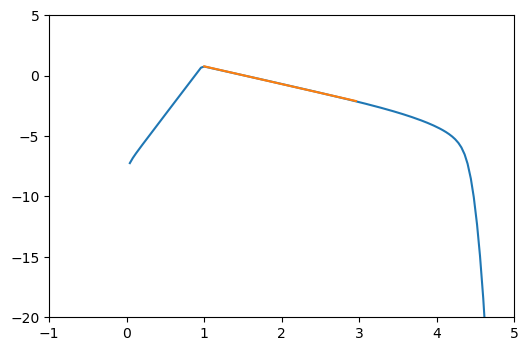

In [16]:
p_e=-get_p_index(temp_ev_acc_flare,3E4,1,3,plot=True)

p= [-1.41274652  2.01244667]


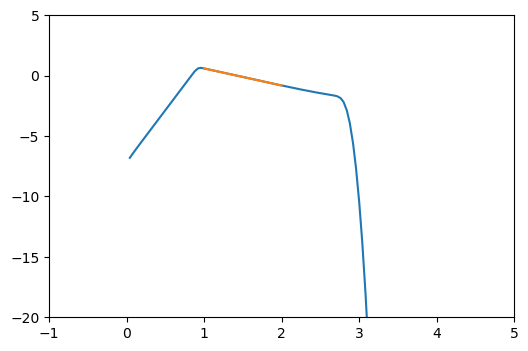

In [24]:
p_e=-get_p_index(temp_ev_expansion_cooling,1E6,1,2,plot=True)

In [10]:
def SED_peak_analysis(temp_ev_acc_flare,temp_ev_expansion,table_lc,ID_beta,nu_obs=15E9,nu_SSA_0=173E9,log_g_min=1,log_g_max=3,c=0.5,ssa_index=2.5):
    z=temp_ev_acc_flare.rad_region.jet.parameters.z_cosm.val

    R0=temp_ev_acc_flare.rad_region.jet.parameters.R.val
    delta=temp_ev_acc_flare.rad_region.jet.parameters.beam_obj.val
    flare_duration_obs=temp_ev_acc_flare.parameters.duration.val/delta*(1+z)

    m_B=temp_ev_expansion.parameters.m_B.val
    t_exp=temp_ev_expansion.parameters.t_jet_exp.val 
    

    tp_observed=table_lc['t_peak_radio'][ID_beta]*86400-flare_duration_obs

    
    p_e=-get_p_index(temp_ev_expansion,tp_observed,log_g_min,log_g_max,plot=True)
    nu_0=get_nu_SSA(p_e,nu_SSA_0)

    tp_predicted=delta_t_obs(z=z,delta=delta,t_exp=t_exp,beta_exp=table_lc['beta_exp'][ID_beta],R0=R0,nu_0=nu_0,nu_r=nu_obs,p=p_e,m_B=m_B)-flare_duration_obs

    print('%e'%tp_predicted,'%e'%tp_observed,tp_predicted/tp_observed)
    p=temp_ev_expansion.plot_tempev_model(density=True,time=0,frame='obs',use_cached=True)
    p.sedplot.lines[0].set_label('t=start')
    p.sedplot.lines[0].set_linestyle('-')

    s=temp_ev_expansion.rad_region.get_SED(comp='Sync',time=tp_observed,frame='obs',use_cached=True)
    p=temp_ev_expansion.plot_tempev_model(density=True,time=tp_observed,frame='obs',use_cached=True,plot_obj=p)
    p.sedplot.lines[1].set_label('peak')
    p.sedplot.lines[1].set_color('green')
    p.sedplot.lines[1].set_label('t=observed peak')
    p.sedplot.lines[1].set_linestyle('-')
    ID_tp=np.argmax(s.nuFnu.value/s.nu.value)
    nu_tp=s.nu.value[ID_tp]

    s=temp_ev_expansion.rad_region.get_SED(comp='Sync',time=tp_predicted,frame='obs',use_cached=True)
    p=temp_ev_expansion.plot_tempev_model(density=True,time=tp_predicted,frame='obs',use_cached=True,plot_obj=p)
    p.sedplot.lines[2].set_label('t=predicted peak')
    p.sedplot.lines[2].set_color('blue')
    p.sedplot.lines[2].set_linestyle('--')
    ID=np.argmax(s.nuFnu.value/s.nu.value)
    nu=s.nu.value[ID]


    p.sedplot.axvline(np.log10(15E9),ls='--',c='black')
    p.sedplot.axvline(np.log10(nu_0),ls='--',c='red')

    x_pl=np.linspace(12,8,100)

    m=get_evenlope_index(m_B,p_e,c=c,ssa_index=ssa_index)

    y_0=-23.25
    q=y_0-m*np.log10(nu_0)
    y_pl=m*x_pl+q
    p.sedplot.plot(x_pl,y_pl,ls='--',label='predicted envelope')
    p.sedplot.legend()
    p.sedplot.set_xlim(8,16)
    p.sedplot.set_ylim(-25,-23)
    p.resplot.remove()
    p.fig.set_size_inches(9,6)
    p.fig.set_dpi(90)
    update_sed_plot(p)
    p.sedplot.legend(loc='upper right')


p= [-1.46564896  1.14197418]
8.357633e+06 7.572640e+06 1.1036616948839753
m 0.9 m_B 2
p= [-1.46564896  0.48602134]
1.570316e+07 1.627764e+07 0.9647075832299906
m 0.6339468283350947 m_B 1.0


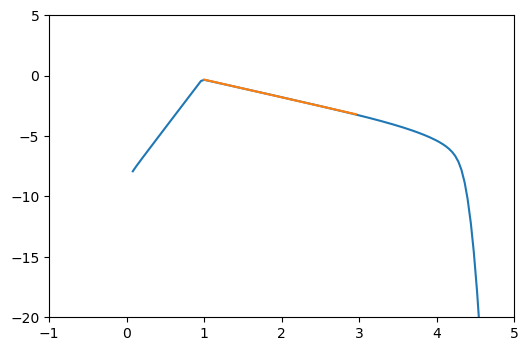

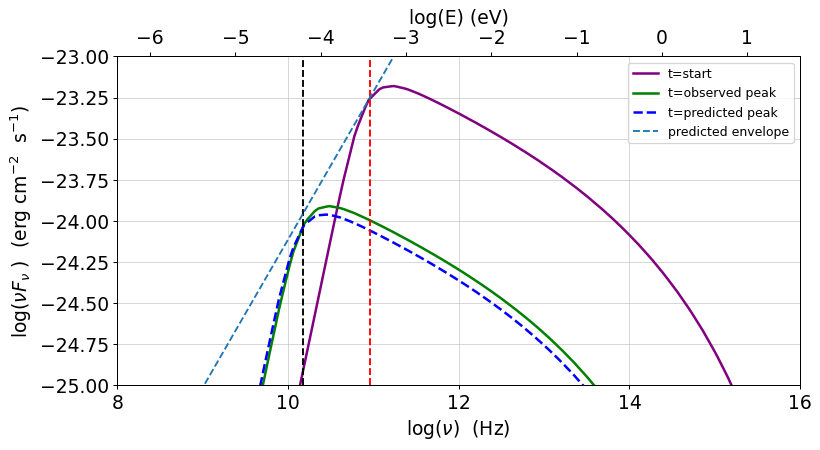

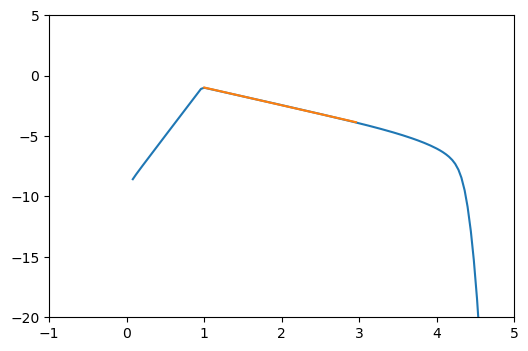

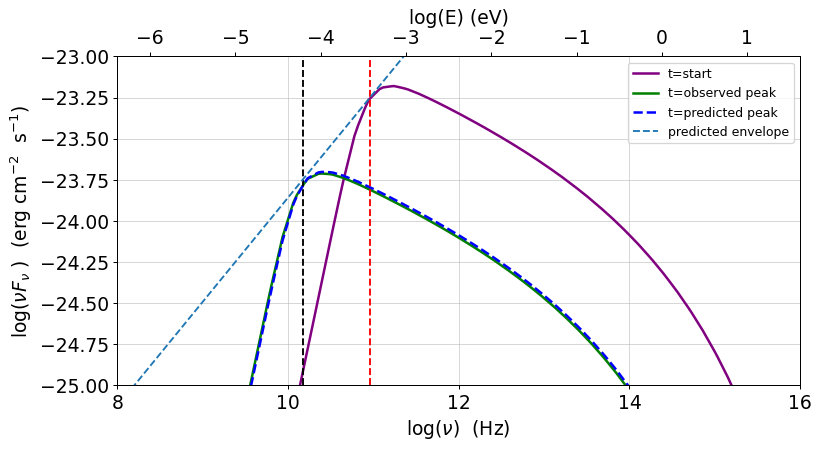

In [11]:
SED_peak_analysis(temp_ev_acc_flare,temp_ev_expansion_no_cooling_m_B_2,table_no_cooling_m_B_2,ID_beta,nu_obs=15E9,ssa_index=1.,c=0.1)
SED_peak_analysis(temp_ev_acc_flare,temp_ev_expansion_no_cooling,table_no_cooling,ID_beta,nu_obs=15E9,ssa_index=1,c=0.5)

In [12]:
p.fig.savefig('Phenomenology_validation/delay_anticipation_no_cooling.pdf',bbox_inches = 'tight',
    pad_inches = 0)

NameError: name 'p' is not defined

In [ ]:
SED_peak_analysis(temp_ev_acc_flare,temp_ev_expansion_cooling,table_cooling,ID_beta,nu_obs=15E9,log_g_min=1,log_g_max=1.5)

In [ ]:
p.fig.savefig('Phenomenology_validation/delay_anticipation_cooling.pdf',bbox_inches = 'tight',
    pad_inches = 0)